In [252]:
import os
import json
import pandas as pd

import seaborn as sns

from os import listdir
from os.path import isfile, join, exists

TMP_DB_SQL = "/tmp/s2_tournament.sql"

logs_dir = "logs/"
logs = [f for f in listdir(logs_dir) if isfile(join(logs_dir, f))]
games = []
for log in logs:
    with open(logs_dir + "/" + log, "r") as f:
        games.append(json.load(f))

import sqlite3
if exists(TMP_DB_SQL):
    os.remove(TMP_DB_SQL)
con = sqlite3.connect(TMP_DB_SQL)
cur = con.cursor()
cur.execute('CREATE TABLE event_kill ("game", "round", "timestamp", "killerPlayfabId", "killerTeam", "victimPlayfabId", "victimTeam", "weaponName");')
cur.execute('CREATE TABLE round ("game", "round", "mapName", "startTime", "endTime");')
cur.execute('CREATE TABLE player ("id", "name", "tier", "team");')


kills = []
for game in games:
    for round_no, round in enumerate(game["rounds"]):
        row = round
        row["round"] = round_no
        row["game"] = game["startTime"]
        cur.execute('insert into round values (:game, :round, :mapName, :startTime, :endTime)', row)
        for event in round["events"]:
            if event["type"] == "PLAYER_KILL":
                row = event
                del row["type"]
                row["game"] = game["startTime"]
                row["round"] = round_no
                cur.execute(
                    'insert into event_kill values (:game, :round, :timestamp, :killerPlayfabId, :killerTeam, :victimPlayfabId, :victimTeam, :weaponName)',
                    row)
con.commit()

In [253]:
players = [
    ["9EDB977D8849AD0C", "papu", 18, "WeAreTeam7"],
    ["EBA9074566BEA3E7", "proto", 16, "BaseHot"],
    ["EDB92702EC149828", "nino", 17, "Maroon5"],
    ["C19637F2290726EB", "haste", 13, "DotDotDot"],
    ["6446A9422BE1BD7D", "dD", 13, "NoMoreOverheat"],
    ["82FC63DE46014718", "YnGwi3", 13, "2Tilted"],
    ["D35B7050036AAD3", "fri", 13, "Mortals"],
    ["C42975C9A8E4E66B", "Psycho", 11, "DotDotDot"],
    ["517348F5DF244DE5", "Anna", 11, "Maroon5"],
    ["9AB6234BDDCE14D9", "dbfseventsd", 11, "Mortals"],
    ["9DD00BA9F5AA7525", "Norbo11", 10, "2Tilted"],
    ["47167D5CB3751A2C", "challz", 9, "NoMoreOverheat"],
    ["CF4B8D60F1735398", "thyro", 8, "WeAreTeam7"],
    ["D482320672E27418", "Jok", 8, "BaseHot"],
    ["784CD6C79930CC43", "evhO", 7, "BaseHot"],
    ["6AF4A5EF7DB4F012", "kahukerr", 1, "Mortals"],
    ["85D4CB1D1C2A72CD", "xQ:Le1T0r", 7, "WeAreTeam7"],
    ["B83C6CC780CDF96C", "SigHunter", 6, "2Tilted"],
    ["F029E4BFE212BE18", "Morgoth", 5, "Maroon5"],
    ["298FD01685544F0", "danyukhin", 0, "DotDotDot"],
    ["DEEA9A62468B4158", "kevin16king", 0, "NoMoreOverheat"],
]
cur.executemany("insert into player values(?,?,?,?)", players)
cur.connection.commit()

pd.read_sql_query("select * from player", con).head()

,id,name,tier,team
0,9EDB977D8849AD0C,papu,18,WeAreTeam7
1,EBA9074566BEA3E7,proto,16,BaseHot
2,EDB92702EC149828,nino,17,Maroon5
3,C19637F2290726EB,haste,13,DotDotDot
4,6446A9422BE1BD7D,dD,13,NoMoreOverheat


In [254]:
cur.execute('CREATE TABLE tier ("id", "name");')
players = [
    [0, "UNRANKED"],
    [1, "BRONZE_I"],
    [2, "BRONZE_II"],
    [3, "BRONZE_III"],
    [4, "SILVER_I"],
    [5, "SILVER_II"],
    [6, "SILVER_III"],
    [7, "GOLD_I"],
    [8, "GOLD_II"],
    [9, "GOLD_III"],
    [10, "PLATINUM_I"],
    [11, "PLATINUM_II"],
    [12, "PLATINUM_III"],
    [13, "DIAMOND_I"],
    [14, "DIAMOND_II"],
    [15, "DIAMOND_III"],
    [16, "CHAMPION_I"],
    [17, "CHAMPION_II"],
    [18, "CHAMPION_III"],
]
cur.executemany("insert into tier values(?,?)", players)
cur.connection.commit()

# Charts

## Maps played

<AxesSubplot: xlabel='count', ylabel='mapName'>

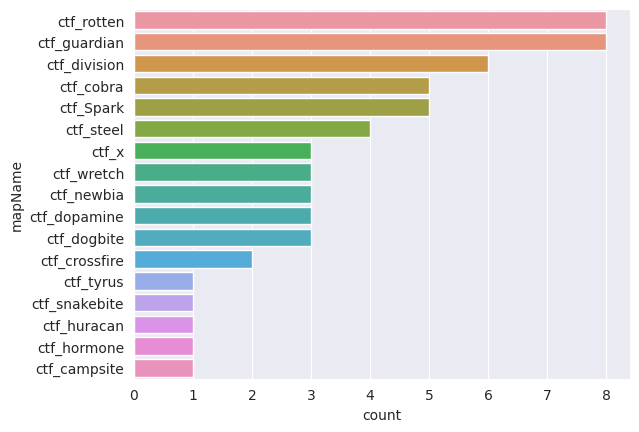

In [255]:
sns.barplot(pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con),
            y="mapName", x="count")

## Weapons

### Kills per weapon

<AxesSubplot: xlabel='count', ylabel='weaponName'>

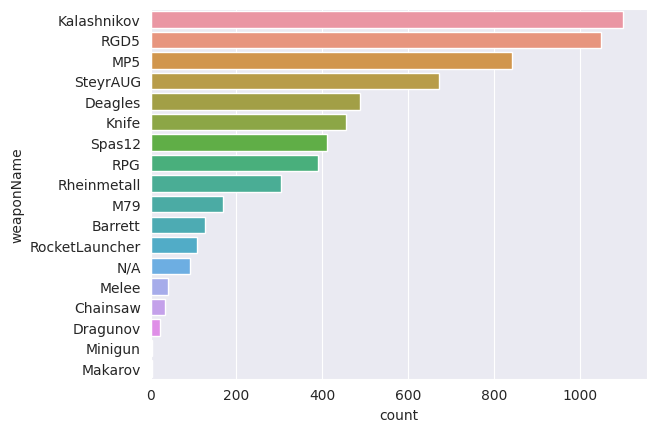

In [256]:
sns.barplot(pd.read_sql_query("select weaponName, count(1) as count from event_kill group by weaponName order by count desc", con),
            y="weaponName", x="count")

In [257]:
## kills per player, top 10

<AxesSubplot: xlabel='count', ylabel='name'>

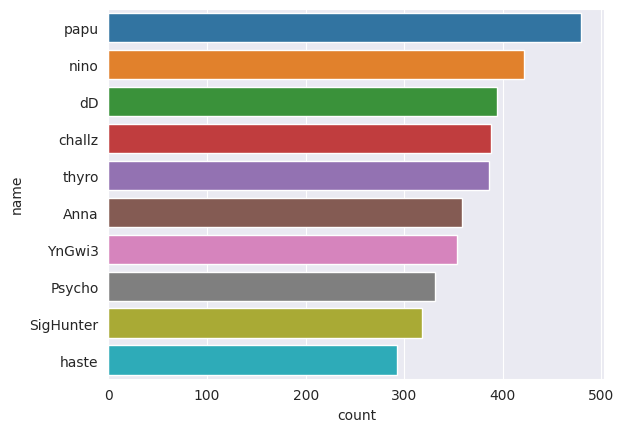

In [258]:
query = """
select player.name as name, count(1) as count from event_kill
    join player on id = killerPlayfabId
    group by killerPlayfabId order by count desc limit 10"""
sns.barplot(pd.read_sql_query(query, con), y="name", x="count")

### k/d per player

<AxesSubplot: xlabel='kd', ylabel='name'>

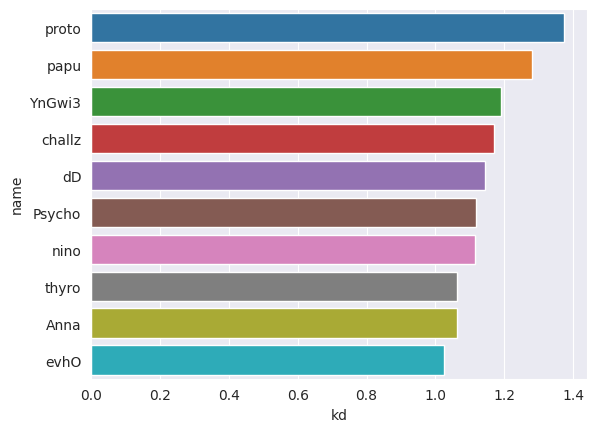

In [262]:
query = """
select name,
       round(1.0 * (select count(1) from event_kill where killerPlayfabId = id)/(select count(1) from event_kill where victimPlayfabId = id), 3) as kd
       from player order by kd desc limit 10
    """
data = pd.read_sql_query(query, con)
sns.barplot(data, y="name", x="kd")

## k/d per team

<AxesSubplot: xlabel='kd', ylabel='team'>

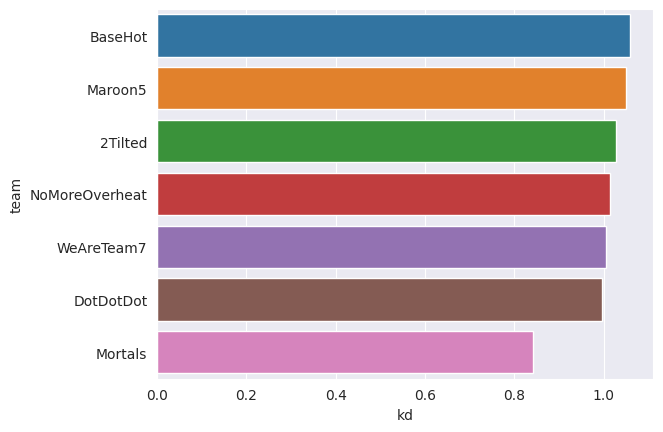

In [261]:
query = """
select distinct team,
    round(1.0 * (select count(1) from event_kill ek join player p on ek.killerPlayfabId = p.id where p.team = player.team)/
    (select count(1) from event_kill ek join player p on ek.victimPlayfabId = p.id where p.team = player.team),3) as kd
from player order by kd desc;
    """
data = pd.read_sql_query(query, con)
sns.barplot(data, y="team", x="kd")